In [1]:
from pathlib import Path
from models import utils as mutils
import sampling
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      LangevinCorrectorCS)
# from models import ncsnpp
from itertools import islice
from losses import get_optimizer
import datasets
import time
import controllable_generation_TV
from utils import restore_checkpoint, fft2, ifft2, show_samples_gray, get_mask, clear
import torch
import torch.nn as nn
import numpy as np
from models.ema import ExponentialMovingAverage
from scipy.io import savemat, loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt
import importlib
import torchvision
from models import ncsnpp

In [2]:
###############################################
# Configurations
###############################################
problem = 'Fourier_CS_3d_admm_tv'
config_name = 'fastmri_knee_320_ncsnpp_continuous'
sde = 'VESDE'
num_scales = 2000
ckpt_num = 95
N = num_scales

root = './data/MRI/BRATS'
vol = 'Brats18_CBICA_AAM_1'

if sde.lower() == 'vesde':
  # from configs.ve import fastmri_knee_320_ncsnpp_continuous as configs
  configs = importlib.import_module(f"configs.ve.{config_name}")
  if config_name == 'fastmri_knee_320_ncsnpp_continuous':
    ckpt_filename = f"./exp/ve/{config_name}/checkpoint_{ckpt_num}.pth"
  elif config_name == 'ffhq_256_ncsnpp_continuous':
    ckpt_filename = f"exp/ve/{config_name}/checkpoint_48.pth"
  config = configs.get_config()
  config.model.num_scales = num_scales
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sde.N = N
  sampling_eps = 1e-5

img_size = 240
batch_size = 1
config.training.batch_size = batch_size
predictor = ReverseDiffusionPredictor
corrector = LangevinCorrector
probability_flow = False
snr = 0.16
n_steps = 1

In [3]:
# parameters for Fourier CS recon
mask_type = 'uniform1d'
use_measurement_noise = False
acc_factor = 2.0
center_fraction = 0.15

In [ ]:
config.device = torch.device('cpu')
print("device: ",config.device)

import os

m_gpu=0
torch.cuda.device_count()
os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % m_gpu
torch.cuda.set_device(m_gpu)
torch.cuda.is_available()
torch.cuda.current_device()
config.device = torch.device(torch.cuda.current_device())
print("device now: ",config.device)

In [4]:
print("device now: ",config.device)

device now:  cuda:0


In [5]:
# ADMM TV parameters
lamb_list = [0.005]
rho_list = [0.01]

random_seed = 0

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)
state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
ema.copy_to(score_model.parameters())

fname_list = sorted(list((Path(root) / vol).glob('*.npy')))
all_img = []
for fname in tqdm(fname_list):
    img = np.load(fname)
    img = torch.from_numpy(img)
    h, w = img.shape
    img = img.view(1, 1, h, w)
    all_img.append(img)

all_img = torch.cat(all_img, dim=0)

loaded checkpoint dir from exp/ve/fastmri_knee_320_ncsnpp_continuous/checkpoint_95.pth


100%|██████████| 155/155 [00:00<00:00, 292.90it/s]


In [6]:
# normalize the volume to be in proper range
vmax = all_img.max()
all_img /= (vmax + 1e-5)

img = all_img.to(config.device)
b = img.shape[0]

In [7]:
for lamb in lamb_list:
    for rho in rho_list:
        print(f'lambda: {lamb}')
        print(f'rho:    {rho}')
        # Specify save directory for saving generated samples
        save_root = Path(f'./results/{config_name}/{problem}/{mask_type}/acc{acc_factor}/lamb{lamb}/rho{rho}/{vol}')
        save_root.mkdir(parents=True, exist_ok=True)

        irl_types = ['input', 'recon', 'label']
        for t in irl_types:
            save_root_f = save_root / t
            save_root_f.mkdir(parents=True, exist_ok=True)

        ###############################################
        # Inference
        ###############################################

        # forward model
        kspace = fft2(img)

        # generate mask
        mask = get_mask(torch.zeros(1, 1, h, w), img_size, batch_size,
                        type=mask_type, acc_factor=acc_factor, center_fraction=center_fraction)
        mask = mask.to(img.device)
        mask = mask.repeat(b, 1, 1, 1)

        pc_fouriercs = controllable_generation_TV.get_pc_radon_ADMM_TV_mri(sde,
                                                                           predictor, corrector,
                                                                           inverse_scaler,
                                                                           mask=mask,
                                                                           lamb_1=lamb,
                                                                           rho=rho,
                                                                           img_shape=img.shape,
                                                                           snr=snr,
                                                                           n_steps=n_steps,
                                                                           probability_flow=probability_flow,
                                                                           continuous=config.training.continuous)

        # undersampling
        under_kspace = kspace * mask
        under_img = torch.real(ifft2(under_kspace))

        count = 0
        for i, recon_img in enumerate(under_img):
            plt.imsave(save_root / 'input' / f'{count}.png', clear(under_img[i]), cmap='gray')
            plt.imsave(save_root / 'label' / f'{count}.png', clear(img[i]), cmap='gray')
            count += 1

        x = pc_fouriercs(score_model, scaler(under_img), measurement=under_kspace)

        count = 0
        for i, recon_img in enumerate(x):
            plt.imsave(save_root / 'input' / f'{count}.png', clear(under_img[i]), cmap='gray')
            plt.imsave(save_root / 'label' / f'{count}.png', clear(img[i]), cmap='gray')
            plt.imsave(save_root / 'recon' / f'{count}.png', clear(recon_img), cmap='gray')
            np.save(str(save_root / 'input' / f'{count}.npy'), clear(under_img[i], normalize=False))
            np.save(str(save_root / 'recon' / f'{count}.npy'), clear(x[i], normalize=False))
            np.save(str(save_root / 'label' / f'{count}.npy'), clear(img[i], normalize=False))
            count += 1

lambda: 0.005
rho:    0.01


/data0/tzc/MRI/DiffusionMBIR/utils.py:101: RuntimeWarning: invalid value encountered in divide
  img /= np.max(img)
100%|██████████| 2000/2000 [10:44:45<00:00, 19.34s/it] 


In [10]:
np.save(str(save_root / 'x.npy'), x.cpu().numpy())

In [12]:
x.size()

torch.Size([155, 1, 240, 240])

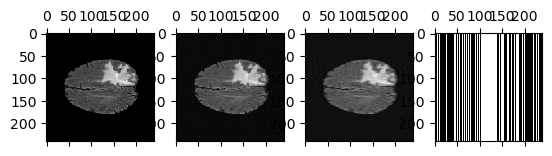

In [28]:
sample=95

fig, axes = plt.subplots(nrows=1, ncols=4)

axes[0].matshow(img[sample][0].cpu().numpy(),cmap='gray')

axes[1].matshow(x[sample][0].cpu().numpy(),cmap='gray')

axes[2].matshow(under_img[sample][0].cpu().numpy(),cmap='gray')

axes[3].matshow(mask[sample][0].cpu().numpy(),cmap='gray')

将结果转为volume

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load("/data0/tzc/MRI/DiffusionMBIR/results/fastmri_knee_320_ncsnpp_continuous/Fourier_CS_3d_admm_tv/uniform1d/acc2.0/lamb0.005/rho0.01/Brats18_CBICA_AAM_1/x.npy")
x.shape

(155, 1, 240, 240)

In [8]:
volume = x.reshape(155,240,240)
std_x = img.cpu().numpy().reshape(155,240,240)

(-0.5, 239.5, 239.5, -0.5)

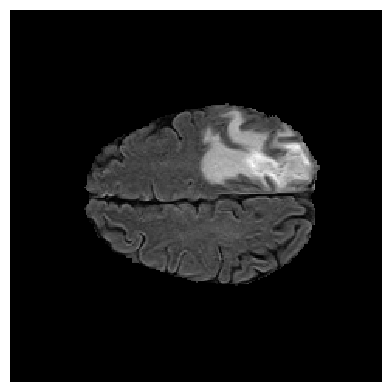

In [15]:
# 假设volume是形状为(150, 240, 240)的三维张量

# 选择要可视化的切片位置
slice_index_z = 105
slice_index_x = 130
slice_index_y = 130


plt.matshow(std_x[slice_index_z, :, :], cmap='gray')
plt.axis('off')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].matshow(volume[slice_index_z, :, :], cmap='gray')
axes[0].axis('off')
axes[1].matshow(std_x[slice_index_z, :, :], cmap='gray')
axes[1].axis('off')

(-0.5, 239.5, 154.5, -0.5)

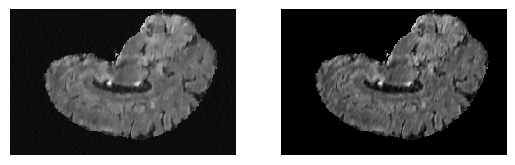

In [18]:
# 可视化切片
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].matshow(volume[:, slice_index_x, :], cmap='gray')
axes[0].axis('off')
axes[1].matshow(std_x[:, slice_index_x, :], cmap='gray')
axes[1].axis('off')

(-0.5, 239.5, 154.5, -0.5)

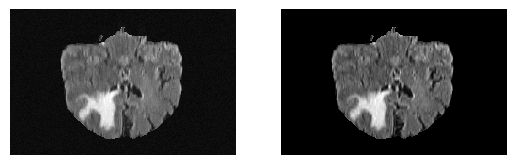

In [19]:
# 可视化切片
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].matshow(volume[:, :, slice_index_y], cmap='gray')
axes[0].axis('off')
axes[1].matshow(std_x[:, :, slice_index_y], cmap='gray')
axes[1].axis('off')

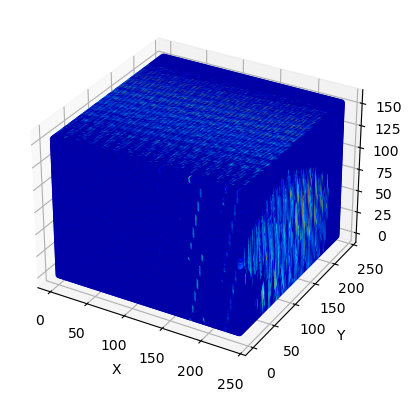

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# 假设volume是形状为(150, 240, 240)的三维张量
# volume = np.random.rand(150, 240, 240)  # 替换为您的数据

# 创建一个三维坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 获取volume的形状
depth, height, width = volume.shape

# 创建一个网格，表示体素的位置
x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.arange(depth))

# 将体素的位置和体素的属性值绘制成散点图
ax.scatter(x, y, z, c=volume, cmap='jet', marker='o', s=10)

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示可视化结果
plt.show()

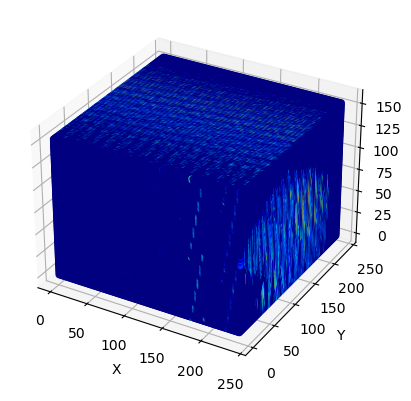

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# 假设volume是形状为(150, 240, 240)的三维张量
# volume = np.random.rand(150, 240, 240)  # 替换为您的数据

# 创建一个三维坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 获取volume的形状
depth, height, width = volume.shape

# 创建一个网格，表示体素的位置
x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.arange(depth))

# 将体素的位置和体素的属性值绘制成散点图
ax.scatter(x, y, z, c=std_x, cmap='jet', marker='o', s=10)

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示可视化结果
plt.show()